In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm


In [2]:
# Prob (a): Dataset creation
def create_dataset(n: int, seed: int = None) -> Tuple[torch.Tensor, torch.Tensor]:
    if seed is not None:
        np.random.seed(seed)
    x = np.random.uniform(0, 1, n)
    y = np.sin(10 * np.pi * x ** 4)
    return torch.FloatTensor(x.reshape(-1, 1)), torch.FloatTensor(y.reshape(-1, 1))

# True function
def f_star(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(10 * np.pi * x ** 4)


In [3]:
# Prob(b): MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_model(X: torch.Tensor, y: torch.Tensor, epochs: int = 2000) -> MLP:
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}', end='\r')

    return model

# Evaluation functions
def compute_delta(model: MLP, x_range: Tuple[float, float], n_points: int = 1000) -> float:
    model.eval()
    x_test = torch.linspace(x_range[0], x_range[1], n_points).reshape(-1, 1)
    with torch.no_grad():
        y_pred = model(x_test)
        y_true = f_star(x_test)
        delta = torch.max(torch.abs(y_pred - y_true)).item()
    return delta

def compute_deltas(model: MLP) -> Tuple[float, float]:
    delta_in = compute_delta(model, (0, 1))
    delta_out = compute_delta(model, (0, 1.5))
    return delta_in, delta_out

def run_experiment(n: int, seed: int = None) -> Tuple[float, float]:
    X, y = create_dataset(n, seed)
    model = train_model(X, y)
    return compute_deltas(model)


In [4]:
# Prob (c): Run experiments
ns = np.logspace(1, 3, 20).astype(int)
results = {n: {'delta_in': [], 'delta_out': []} for n in ns}

for n in tqdm(ns):
    # Create 5 training datasets for each n
    for seed in range(5):
        delta_in, delta_out = run_experiment(n, seed)
        results[n]['delta_in'].append(delta_in)
        results[n]['delta_out'].append(delta_out)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:14<04:29, 14.19s/it]

 10%|█         | 2/20 [00:26<03:57, 13.18s/it]

 15%|█▌        | 3/20 [00:39<03:38, 12.85s/it]

 20%|██        | 4/20 [00:51<03:24, 12.77s/it]

 25%|██▌       | 5/20 [01:04<03:12, 12.84s/it]

 30%|███       | 6/20 [01:17<03:00, 12.92s/it]

 35%|███▌      | 7/20 [01:30<02:48, 12.92s/it]

 40%|████      | 8/20 [01:44<02:39, 13.30s/it]

 45%|████▌     | 9/20 [02:02<02:40, 14.60s/it]

 50%|█████     | 10/20 [02:18<02:30, 15.07s/it]

 55%|█████▌    | 11/20 [02:35<02:19, 15.53s/it]

 60%|██████    | 12/20 [02:53<02:11, 16.40s/it]

 65%|██████▌   | 13/20 [03:07<01:50, 15.74s/it]

 70%|███████   | 14/20 [03:21<01:30, 15.14s/it]

 75%|███████▌  | 15/20 [03:35<01:14, 14.85s/it]

 80%|████████  | 16/20 [03:50<00:59, 14.87s/it]

 85%|████████▌ | 17/20 [04:06<00:45, 15.20s/it]

 90%|█████████ | 18/20 [04:23<00:31, 15.67s/it]

 95%|█████████▌| 19/20 [04:41<00:16, 16.47s/it]

100%|██████████| 20/20 [05:01<00:00, 15.06s/it]

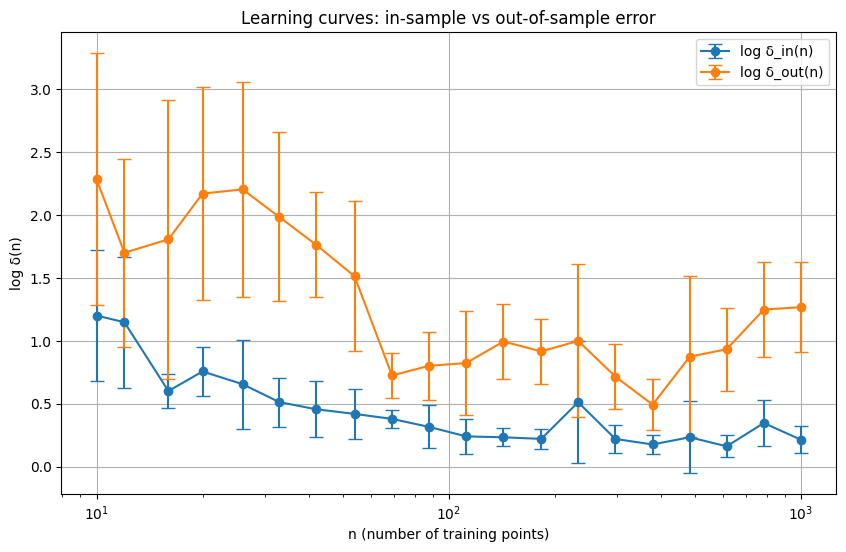

In [5]:
# Compute statistics
delta_in_mean = [np.mean(results[n]['delta_in']) for n in ns]
delta_in_std = [np.std(results[n]['delta_in']) for n in ns]
delta_out_mean = [np.mean(results[n]['delta_out']) for n in ns]
delta_out_std = [np.std(results[n]['delta_out']) for n in ns]

# Create plot
plt.figure(figsize=(10, 6))
plt.errorbar(ns, np.log(delta_in_mean), yerr=np.array(delta_in_std) / np.array(delta_in_mean),
             label='log δ_in(n)', fmt='o-', capsize=5)
plt.errorbar(ns, np.log(delta_out_mean), yerr=np.array(delta_out_std) / np.array(delta_out_mean),
             label='log δ_out(n)', fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('n (number of training points)')
plt.ylabel('log δ(n)')
plt.legend()
plt.grid(True)
plt.title('Learning curves: in-sample vs out-of-sample error')
plt.show()


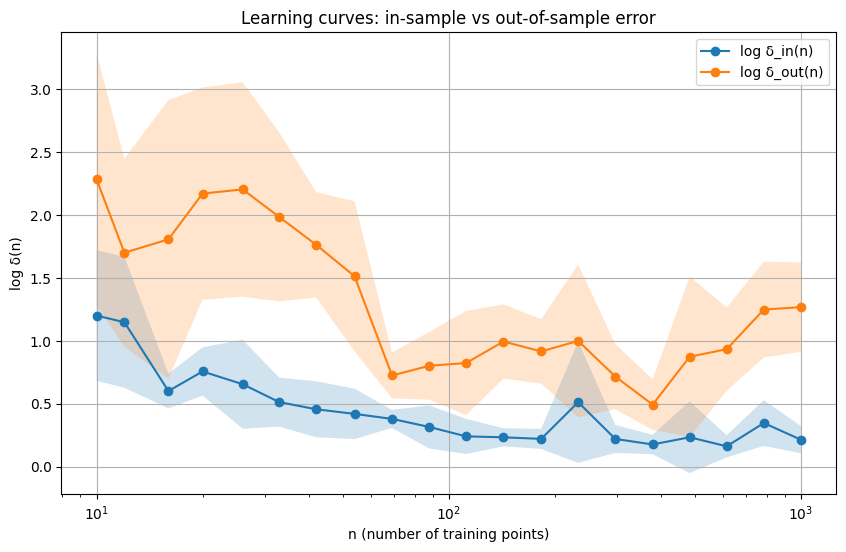

In [6]:
# Compute statistics
delta_in_mean = [np.mean(results[n]['delta_in']) for n in ns]
delta_in_std = [np.std(results[n]['delta_in']) for n in ns]
delta_out_mean = [np.mean(results[n]['delta_out']) for n in ns]
delta_out_std = [np.std(results[n]['delta_out']) for n in ns]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(ns, np.log(delta_in_mean), label='log δ_in(n)', marker='o')
plt.fill_between(ns, np.log(delta_in_mean) - np.array(delta_in_std) / np.array(delta_in_mean),
                 np.log(delta_in_mean) + np.array(delta_in_std) / np.array(delta_in_mean), alpha=0.2)
plt.plot(ns, np.log(delta_out_mean), label='log δ_out(n)', marker='o')
plt.fill_between(ns, np.log(delta_out_mean) - np.array(delta_out_std) / np.array(delta_out_mean),
                 np.log(delta_out_mean) + np.array(delta_out_std) / np.array(delta_out_mean), alpha=0.2)
plt.xscale('log')
plt.xlabel('n (number of training points)')
plt.ylabel('log δ(n)')
plt.legend()
plt.grid(True)
plt.title('Learning curves: in-sample vs out-of-sample error')
plt.show()